In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import datetime

/kaggle/input/tabular-playground-series-jan-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-jan-2022/train.csv
/kaggle/input/tabular-playground-series-jan-2022/test.csv


In [2]:
Train_data = pd.read_csv('/kaggle/input/tabular-playground-series-jan-2022/train.csv')
Test_data = pd.read_csv('/kaggle/input/tabular-playground-series-jan-2022/test.csv')
train_data = Train_data.copy()
test_data = Test_data.copy()

In [3]:
train_date_index = train_data.set_index(pd.to_datetime(train_data['date']))

In [4]:
def minmax_Year(series):
    year = []
    for i in series:
        year.append((i - min(series)) / (max(series) - min(series)))
    return year
a = [2015, 2016, 2017, 2018, 2019]
b = minmax_Year(a)
#Year
def split_Year(date):
    return int(date.split('-')[0])

#Month
def split_month(date):
    return int(date.split('-')[1])

#Day
def split_day(date):
    return int(date.split('-')[2])

#Weekend
def weekend(date):
    weekend = []
    a = pd.to_datetime(date)
    for i in range(len(a)):
        if a.iloc[i].weekday() >= 5 :
            weekend.append(1)
        else:
            weekend.append(0)
    return weekend
#Weekday
def weekday(date):
    import datetime
    weekday = []
    a = pd.to_datetime(date)
    for i in range(len(a)):
        weekday.append(a.iloc[i].weekday())
    return weekday

In [5]:
train_data['Year'] = train_data['date'].apply(split_Year)
train_data['Month'] = train_data['date'].apply(split_month)
train_data['Day'] = train_data['date'].apply(split_day)
train_data['Weekend'] = weekend(train_data['date'])
train_data['Weekday'] = weekday(train_data['date'])
trainyear_minmax = []
for i in train_data['Year']:
    trainyear_minmax.append(b[a.index(i)])
train_data['Year'] = trainyear_minmax
train_data = train_data.drop(columns = ['row_id', 'date', 'Year'])


test_data['Year'] = test_data['date'].apply(split_Year)
test_data['Month'] = test_data['date'].apply(split_month)
test_data['Day'] = test_data['date'].apply(split_day)
test_data['Weekend'] = weekend(test_data['date'])
test_data['Weekday'] = weekday(test_data['date'])
testyear_minmax = []
for i in test_data['Year']:
    testyear_minmax.append(b[a.index(i)])
test_data['Year'] = testyear_minmax
test_data = test_data.drop(columns = ['row_id', 'date','Year'])

In [6]:
#Encoder the 'country', 'store', 'product'
#Dummies the 'country', 'store', 'product'
train_data_dum = pd.get_dummies(train_data[['country', 'store', 'product']])
test_data_dum = pd.get_dummies(test_data[['country', 'store', 'product']])

train_data = pd.concat([train_data, train_data_dum],axis = 1)
test_data = pd.concat([test_data, test_data_dum],axis = 1)

train_data = train_data.drop(columns = ['country', 'store', 'product'])
test_data = test_data.drop(columns = ['country', 'store', 'product'])

In [7]:
data = train_data.drop(columns = 'num_sold')
target = train_data['num_sold']

from sklearn.preprocessing import MinMaxScaler
Normalize = MinMaxScaler()
target = np.log(target)
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data, target, train_size = 0.8, random_state = 5)
x_train = Normalize.fit_transform(x_train)
x_test = Normalize.transform(x_test)


[00:39:00] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


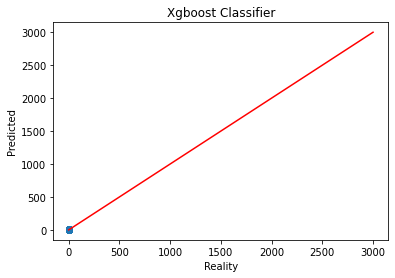

0.9777741870281283


<Figure size 432x288 with 0 Axes>

In [8]:
import xgboost as xgb
XG = xgb.XGBRegressor(objective ='reg:linear', learning_rate = 0.1, alpha = 6, n_estimators = 500).fit(x_train, y_train)
y_pred_XG = XG.predict(x_test)
plt.scatter(y_test, y_pred_XG)
plt.plot([1000*x for x in range(4)], [1000*x for x in range(4)], color = 'r')
plt.xlabel("Reality")
plt.ylabel("Predicted")
plt.title('Xgboost Classifier')
plt.show()
plt.clf()
print(XG.score(x_test, y_test))

In [9]:
XG = xgb.XGBRegressor(objective ='reg:linear', learning_rate = 0.1, alpha = 6, n_estimators = 500).fit(x_train, y_train)

[00:39:05] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


In [10]:
test_data = Normalize.transform(test_data)
submission_target = np.exp(XG.predict(test_data))

In [11]:
submission = pd.read_csv('/kaggle/input/tabular-playground-series-jan-2022/sample_submission.csv')
submission['num_sold'] = submission_target
submission.to_csv('submission.csv', index=False)

In [12]:
submission

,row_id,num_sold
0,26298,307.138031
1,26299,512.250061
2,26300,148.438080
3,26301,525.928772
4,26302,875.039185
...,...,...
6565,32863,863.464294
6566,32864,213.410156
6567,32865,925.301941
6568,32866,1433.967651
